In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

%load_ext autoreload
%autoreload 2
import h5py

from pathlib import Path
from sglm.models import sglm_cv
import itertools
import time
import glob
import numpy as np
import pandas as pd
import numpy as np
from sglm.features import gen_signal_df as gsd
from sglm.features import build_features as bf
from sglm.features import setup_model_fit as smf
from sglm.models import sglm_cv
from sglm import models
from sglm.visualization import visualize
from sglm.models import train_model
from sglm.models import eval
from sglm import features
import sys
import os
from pathlib import Path
import matplotlib.pyplot as plt
import json

from collections import defaultdict

import traceback
import warnings
import sys

In [2]:
# From stack overflow
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

In [3]:
def extract_multifiles(wt_used, signal_files, widest_orders, shift_spacer='_sft_'):
    # needed info
    # Params: wt_used, signal_files, widest_orders, multifile_fit
    # Returns: mouse_names, combo_dfs, combo_fns, X_cols_sftd

    file_ids = [Path(_).parts[-1] for _ in signal_files]
    print('file_ids', file_ids)
    combo_dfs, X_cols_sftd, _ = smf.multi_file_analysis_prep(signal_files, widest_orders, file_ids, shift_spacer='_sft_', keep_unshifted=True)
#     combo_dfs, X_cols_sftd, _ = smf.multi_file_analysis_prep_nosft(signal_files, widest_orders, file_ids)
    combo_fns = ['_'.join(wt_used).replace('WT', '').replace('S', '')]
    mouse_names = combo_fns

    return mouse_names, combo_dfs, combo_fns, X_cols_sftd

In [4]:
def dump_dict_to_json(source_dict, json_path):
    with open(str((json_path).resolve()), 'w') as json_file:
        json.dump(source_dict, json_file)

def read_json(json_path):
    with open(str((json_path).resolve()), 'r') as json_file:
        read_json = json.load(json_file)
    return read_json

In [5]:
def id_rows_with_all_cols(dfrel_basis,
                          X_y_pairings,
                          X_cols_sftd, 
                          drop_cols_basis = ['nTrial', 'nTrial_filenum',
                                             'cpn', 'cpx', 'spnnr', 'spxnr', 'spnr', 'spxr',
                                             
                                             'photometryCenterInIndex', 'photometryCenterOutIndex',
                                             'photometrySideInIndexr', 'photometrySideInIndexnr',
                                             'photometrySideOutIndex', 'spnnrOff',
                                             
                                             'photometrySideInIndexAA', 'photometrySideInIndexAa',
                                             'photometrySideInIndexaA', 'photometrySideInIndexaa',
                                             'photometrySideInIndexAB', 'photometrySideInIndexAb',
                                             'photometrySideInIndexaB', 'photometrySideInIndexab',
#                                              'sl',
#                                              'slOff'
                                            ]):
    full_drop_basis = []
    y_col_lst = []
    for X_y_dct in X_y_pairings:
        full_drop_basis += bf.col_shift_bounds_dict_to_col_list(X_y_dct['X_cols'], X_cols_sftd)
        y_col_lst += [X_y_dct['y_col']]
    y_col_drop_basis = sorted(list(set(y_col_lst)))
    full_drop_basis = sorted(list(set(drop_cols_basis + full_drop_basis + y_col_drop_basis)))

    num_cols_na = (dfrel_basis[full_drop_basis].isna().sum(axis=1))
    num_y_0 = (dfrel_basis[y_col_drop_basis] == 0).sum(axis=1)
    has_all_cols = (num_cols_na == 0)&(num_y_0 == 0)

    return has_all_cols

def warn_with_traceback(message, category, filename, lineno, file=None, line=None):

    log = file if hasattr(file,'write') else sys.stderr
    traceback.print_stack(file=log)
    log.write(warnings.formatwarning(message, category, filename, lineno, line))

warnings.showwarning = warn_with_traceback

In [6]:
def get_holdout_and_cv_idx(df_available, pholdout, folds, pgss, filter_series, id_cols=['nTrial_filenum']):
    holdout_series = models.split_data.holdout_split_by_trial_id(df_available,
                                                                id_cols=id_cols,
                                                                perc_holdout=pholdout)
    cv_idx_lst = models.split_data.cv_idx_by_trial_id(dfrel_basis_has_all_cols[(~holdout_series)&(filter_series)],
                                                             trial_id_columns=id_cols,
                                                             num_folds=folds,
                                                             test_size=pgss)
    return holdout_series, cv_idx_lst

In [7]:
### Part 1
param_set_json_name = 'full_model_param_set.json'

# source_data_path = Path(r'C:\Users\Josh\Documents\GitHub\sabatinilab-glm\sglm\data\interim')
# output_path = Path(r'C:\Users\Josh\Documents\GitHub\sabatinilab-glm\sglm\outputs_clean')

# source_data_path = Path(r'/Users/josh/Documents/github_repos/sabatinilab-glm/sglm/data/interim')
# output_path = Path(r'/Users/josh/Documents/github_repos/sabatinilab-glm/sglm/outputs_check')

# source_data_path = Path(r'/Users/josh/Documents/github_repos/sabatinilab-glm/sglm/data/mike-GLM_8020-interim')
# output_path = Path(r'/Users/josh/Documents/github_repos/sabatinilab-glm/sglm/outputs-mike-GLM_8020')


source_data_path = Path(r'/Users/josh/Documents/github_repos/sabatinilab-glm/sglm/data/lynne-sanity-interim')
output_path = Path(r'/Users/josh/Documents/github_repos/sabatinilab-glm/sglm/outputs_lynne-sanity')

preproc_params_name = r'preproc_params.json'
basis_name = r'_basis.csv'
# figname = 'fig_8020'
figname = 'Figure_1'
groupid = 'g1'
param_set_id = '-20_+20_rwd_wco'


In [8]:
param_set_output_path = output_path / Path(figname) / Path(groupid) / Path(param_set_id)
param_set_dct = read_json(param_set_output_path / param_set_json_name)

source_data_path = Path(param_set_dct['source_data_path'])
output_path = Path(param_set_dct['output_path'])
basis_name = param_set_dct['basis_name']
figname = param_set_dct['figname']
groupid = param_set_dct['groupid']
param_set_id = param_set_dct['param_set_id']
neg_order = param_set_dct['neg_order']
pos_order = param_set_dct['pos_order']
fix_training = param_set_dct['fix_training']
num_runs = param_set_dct['num_runs']
folds = param_set_dct['folds']
pholdout = param_set_dct['pholdout']
pgss = param_set_dct['pgss']
score_method = param_set_dct['score_method']
val_test_inx_sel_method = param_set_dct['val_test_inx_sel_method']
X_y_pairings_lst = param_set_dct['X_y_pairings_lst']
kwargs_iterations = param_set_dct['kwargs_iterations']
kwargs_fixed = param_set_dct['kwargs_fixed']
dfrr_cols = param_set_dct['dfrr_cols']
count_event_names = param_set_dct['count_event_names']

glm_kwarg_lst = sglm_cv.generate_mult_params(kwargs_iterations, kwargs_fixed)

In [9]:
### Part 1
data_path = (source_data_path / figname / groupid)

# interim_preproc_errors_path = data_path / 'interim_preproc_errors.csv'
# interim_preproc_errors_df = pd.read_csv(str(interim_preproc_errors_path.resolve()))
# error_file_list = interim_preproc_errors_df['out_file_errors'].to_list()

error_file_list = []

# preproc_params = read_json(source_data_path / preproc_params_name)
# dump_dict_to_json(preproc_params, param_set_output_path / preproc_params_name)



# basis = pd.read_csv(source_data_path / basis_name, index_col=0)
# basis['mouseid'] = basis['mouseid'].astype(str)
glm_siw = ['GLM_SIGNALS_INTERIM_WT63_11102021.txt', 'GLM_SIGNALS_INTERIM_WT63_11122021.txt', 'GLM_SIGNALS_INTERIM_WT63_11162021.txt',
           'GLM_SIGNALS_INTERIM_WT63_11182021.txt', 'GLM_SIGNALS_INTERIM_WT64_11082021.txt', 'GLM_SIGNALS_INTERIM_WT64_11102021.txt',
           'GLM_SIGNALS_INTERIM_WT64_11122021.txt', 'GLM_SIGNALS_INTERIM_WT64_11162021.txt', 'GLM_SIGNALS_INTERIM_WT64_11182021.txt',
           'GLM_SIGNALS_INTERIM_WT65_11082021.txt', 'GLM_SIGNALS_INTERIM_WT65_11102021.txt', 'GLM_SIGNALS_INTERIM_WT65_11122021.txt',
           'GLM_SIGNALS_INTERIM_WT65_11162021.txt', 'GLM_SIGNALS_INTERIM_WT65_11182021.txt']

glm_siw = [_.replace('.txt', '.csv') for _ in glm_siw]

basis = pd.DataFrame(glm_siw).rename({0: 'signal_file_out'}, axis=1)
basis['mouseid'] = basis['signal_file_out'].str.replace('GLM_SIGNALS_INTERIM_', '').str.slice(0,4)
basis['figname'] = 'Figure_1_2'
basis['groupid'] = 'g1'
# basis

# basis = pd.read_csv(source_data_path / basis_name, index_col=0)
# basis['mouseid'] = basis['mouseid'].astype(str)
relevant_basis = basis[(basis['figname'] == figname)&(basis['groupid'] == groupid)]
wt_used = basis['mouseid'].tolist()

In [10]:
# Load Signal Data
signal_files = []
mouse_names = []
for inx, basis_row in basis.iterrows():
    signal_file_out = basis_row['signal_file_out']
    
    if signal_file_out in error_file_list:
        print(f'Preprocessing error found for file: {signal_file_out}')
        continue
    
    signal_path = data_path / signal_file_out
    signal_files.append(str(signal_path.resolve()))
    mouse_names.append(basis_row['mouseid'])

In [11]:
# # Part 2: Generate base files to use by all runs and create folders for each run

# max_cols_len_lst = [max([len(_['X_cols']) for _ in inner_list]) for inner_list in X_y_pairings_lst]
# multi_start = time.time()
# for iXyp, X_y_pairings in enumerate(X_y_pairings_lst):

#     widest_orders = smf.xy_pairs_to_widest_orders([{'X_cols': smf.X_cols_dict_to_default(_['X_cols'], neg_order, pos_order),
#                                                     'y_col': _['y_col']} for _ in X_y_pairings])
#     max_cols_len = max_cols_len_lst[iXyp]
# #     mouse_names, combo_dfs, combo_fns, X_cols_sftd = extract_multifiles(wt_used, signal_files, widest_orders)
    
#     file_ids = [Path(_).parts[-1] for _ in signal_files]
#     signal_df, signal_df_unsft = smf.multi_file_analysis_prep(signal_files, widest_orders, file_ids)
#     combo_fns = ['_'.join(wt_used).replace('WT', '').replace('S', '')]
#     mouse_names = combo_fns
    
#     break

# whr = np.where(signal_df.fillna(-1) != signal_df_unsft.fillna(-1))
# signal_df.iloc[whr[0][:10],whr[1][:10]]

# signal_df_unsft.iloc[whr[0][:10],whr[1][:10]]
# break

In [12]:
# plot_width = 2
# plot_rows_lst = [_//plot_width + (_%plot_width > 0)*1 for _ in max_cols_len_lst]

In [13]:
# # Part 2: Generate base files to use by all runs and create folders for each run

# max_cols_len_lst = [max([len(_['X_cols']) for _ in inner_list]) for inner_list in X_y_pairings_lst]
# for iXyp, X_y_pairings in enumerate(X_y_pairings_lst):
    
#     Xyp_path = param_set_output_path / Path(f'iXyp_{iXyp}')
#     Xyp_path.mkdir(parents=True, exist_ok=False)
#     dump_dict_to_json(X_y_pairings, Xyp_path / Path('X_y_pairings.json'))
    
    
#     widest_orders = smf.xy_pairs_to_widest_orders([{'X_cols': smf.X_cols_dict_to_default(_['X_cols'], neg_order, pos_order),
#                                                     'y_col': _['y_col']} for _ in X_y_pairings])
#     max_cols_len = max_cols_len_lst[iXyp]
#     mouse_names, combo_dfs, combo_fns, X_cols_sftd = extract_multifiles(wt_used, signal_files, widest_orders, shift_spacer='_sft_')
    
#     start = time.time()
#     results_dict = {}
    
#     dfrel_basis = combo_dfs[0].reset_index(drop=False).copy()
    
# #     fn = Path(combo_fns[file_num].split('.')[0]).parts[-1]
    
#     mouse_id = mouse_names[0]
#     dfresids_cols = np.copy(dfrr_cols).tolist()
# #     run_id = f'{fn}_{iXyp}'         
#     has_all_cols = id_rows_with_all_cols(dfrel_basis, X_y_pairings, X_cols_sftd)
#     if has_all_cols.sum() == 0:
#         print(f'No datapoints found for non-NaN dropcols & non-zero ycols for fixed_training: {prefix}_{fn}')
#         continue

#     dfrel_basis['has_all_cols'] = has_all_cols    
#     basis_column_indices = {
#         'basis_cols': list(dfrel_basis.columns),
#         'basis_index': list(dfrel_basis.index),
#     }
#     dump_dict_to_json(basis_column_indices, Xyp_path / Path('basis_column_indices.json'))
    
    
# #     dfrel_basis[dfresids_cols].set_index(['nTrial_filenum'], append=True).to_hdf(str((Xyp_path / Path(f'combo_df.h5')).resolve()), key='combo', index=True,)
# #     dfrel_basis[dfresids_cols].set_index(['nTrial_filenum'], append=True).to_csv(str((Xyp_path / Path(f'combo_df.csv')).resolve()), index=True)
#     dfrel_basis[[_ for _ in dfrel_basis.columns if '_sft_' not in _]].to_csv(str((Xyp_path / Path(f'combo_df.csv')).resolve()), index=True)
# #     dfrel_basis.to_hdf(str((Xyp_path / Path(f'combo_df.hd5')).resolve()), key='holdout', index=True)
    
# #     dfrel_basis_reload = pd.read_csv(str((Xyp_path / Path(f'combo_df.csv')).resolve()), index_col=0)
# #     dfrel_basis_reload, X_cols_sftd_reload = smf.timeshift_vals_by_dict(dfrel_basis_reload, widest_orders, keep_nans=True,
# #                                                                         groupby_cols=['file_num'], shift_spacer='_sft_')
    
#     dfrel_basis_has_all_cols = dfrel_basis[dfrel_basis['has_all_cols']]
#     cv_holdout_idx_params = dict(df_available=dfrel_basis_has_all_cols,
#                                  pholdout=pholdout,
#                                  folds=folds,
#                                  pgss=pgss,
#                                  filter_series=dfrel_basis_has_all_cols['wi_trial_keep'],
#                                  id_cols=['nTrial_filenum'])
    
#     for irun in range(num_runs):
#         holdout_irun, cv_idx_irun = get_holdout_and_cv_idx(**cv_holdout_idx_params)
        
#         for iXyd, X_y_dct in enumerate(X_y_pairings):
#             holdout_iXyd, cv_idx_iXyd = get_holdout_and_cv_idx(**cv_holdout_idx_params)
            
#             for igkwargs, glm_kwargs in enumerate(glm_kwarg_lst):
#                 holdout_igkwargs, cv_idx_igkwargs = get_holdout_and_cv_idx(**cv_holdout_idx_params)
                
#                 run_path = Xyp_path / Path(f'iXyd_{iXyd}-ikwargs_{igkwargs}') / Path(f'irun_{irun}')
#                 run_path.mkdir(parents=True, exist_ok=False)
                
#                 specific_model_params = {
#                     'mouse_id': mouse_id,
#                     'irun': irun,
#                     'iXyd': iXyd,
#                     'igkwargs': igkwargs,
#                     'X_y_dct': X_y_dct,
#                     'X_cols': bf.col_shift_bounds_dict_to_col_list(X_y_dct['X_cols'], X_cols_sftd, shift_spacer='_sft_'),
#                     'y_col': X_y_dct['y_col'],
#                     'name': X_y_dct['name'],
#                     'glm_kwargs': glm_kwargs,
#                 }
                
#                 dump_dict_to_json(specific_model_params, run_path / Path('specific_model_params.json'))
#                 dump_dict_to_json(param_set_dct, run_path / param_set_json_name)
                
#                 holdout_options_df = pd.DataFrame({'holdout_irun': holdout_irun,
#                                            'holdout_iXyd':holdout_iXyd,
#                                            'holdout_igkwargs':holdout_igkwargs},
#                                           index=dfrel_basis_has_all_cols.index)
                
# #                 holdout_df.to_hdf(str((run_path / 'holdout_options.hd5').resolve()), key='holdout')
                
#                 cv_options_dct = {
#                     'cv_idx_irun':cv_idx_irun,
#                     'cv_idx_iXyd':cv_idx_iXyd,
#                     'cv_idx_igkwargs':cv_idx_igkwargs,
#                 }
# #                 np.save(str((run_path/'cv_options.npy').resolve()), np.array(cv_options_dct, dtype='object'))
                
#                 kfold_cv_idx = cv_options_dct[f'cv_idx_{val_test_inx_sel_method}']
#                 holdout_srs = holdout_options_df[f'holdout_{val_test_inx_sel_method}']
                
#                 np.save(str((run_path/'kfold_cv_idx.npy').resolve()), np.array(kfold_cv_idx, dtype='object'))
                
# #                 holdout_srs.to_hdf(str((run_path / 'holdout.hd5').resolve()), key='holdout')
#                 holdout_srs.to_csv(str((run_path / 'holdout.csv').resolve()), index=True)
                
                
                
#                 ####################################################################################
#                 ####################################################################################
#                 ####################################################################################
#                 ####################################################################################
#                 ####################################################################################
#                 #### JZ TODO: MOVE TO SEPARATE FILE FOR PARALLELIZATION OVER DEEPEST FOLDERS... ####
#                 #### JZ TODO: MOVE TO SEPARATE FILE FOR PARALLELIZATION OVER DEEPEST FOLDERS... ####
#                 #### JZ TODO: MOVE TO SEPARATE FILE FOR PARALLELIZATION OVER DEEPEST FOLDERS... ####
#                 #### JZ TODO: MOVE TO SEPARATE FILE FOR PARALLELIZATION OVER DEEPEST FOLDERS... ####
#                 #### JZ TODO: MOVE TO SEPARATE FILE FOR PARALLELIZATION OVER DEEPEST FOLDERS... ####
#                 ####################################################################################
#                 ####################################################################################
#                 ####################################################################################
#                 ####################################################################################
#                 ####################################################################################
                

In [14]:
# [_ for _ in glob.glob('/Users/josh/Documents/github_repos/sabatinilab-glm/sglm/data/mike-GLM_8020-interim/fig_8020/g1/*') if '03232021' in _]

In [15]:

# max_cols_len_lst = [max([len(_['X_cols']) for _ in inner_list]) for inner_list in X_y_pairings_lst]
# for iXyp, _ in enumerate(X_y_pairings_lst):
#     for irun in range(num_runs):
#         for iXyd, X_y_dct in enumerate(X_y_pairings):
#             for igkwargs, glm_kwargs in enumerate(glm_kwarg_lst):
#                 run_start = time.time()
                
#                 Xyp_path = param_set_output_path / Path(f'iXyp_{iXyp}')
#                 X_y_pairings = read_json(Xyp_path / Path('X_y_pairings.json'))
#                 widest_orders = smf.xy_pairs_to_widest_orders([{'X_cols': smf.X_cols_dict_to_default(_['X_cols'], neg_order, pos_order),
#                                                                 'y_col': _['y_col']} for _ in X_y_pairings])
#                 max_cols_len = max_cols_len_lst[iXyp]
                
#                 run_path = Xyp_path / Path(f'iXyd_{iXyd}-ikwargs_{igkwargs}') / Path(f'irun_{irun}')
#                 specific_model_params = read_json(run_path / Path('specific_model_params.json'))
#                 param_set_dct = read_json(run_path / param_set_json_name)
                
#                 X_cols = specific_model_params['X_cols']
#                 y_col = specific_model_params['y_col']
#                 name = specific_model_params['name']
                
#                 kfold_cv_idx = np.load(str((run_path / 'kfold_cv_idx.npy').resolve()), allow_pickle=True)
#                 holdout_srs = pd.read_csv(str((run_path / 'holdout.csv').resolve()), index_col=0).iloc[:,0]
                
#                 basis_column_indices = read_json(Xyp_path / Path('basis_column_indices.json'))
# #                 print(f'basis_column_indices: index: {len(basis_column_indices["basis_index"])}, columns: {len(basis_column_indices["basis_cols"])}')
#                 dfrel_basis_load = pd.read_csv(str((Xyp_path / Path(f'combo_df.csv')).resolve()))
# #                 print('A: dfrel_basis_load.shape',dfrel_basis_load.shape)



#                 dfrel_basis_load, X_cols_sftd_load = smf.timeshift_vals_by_dict(dfrel_basis_load, widest_orders, keep_nans=True, groupby_cols=['file_num'], shift_spacer='_sft_',)
# #                 print('B: dfrel_basis_load.shape',dfrel_basis_load.shape)
                
#                 X_cols_sftd_load = [_ for _ in basis_column_indices if _ in X_cols_sftd_load]
#                 dfrel_basis = dfrel_basis_load.loc[basis_column_indices['basis_index'], basis_column_indices['basis_cols']]
#                 dfrel_basis = dfrel_basis.copy()
                
# #                 print('X_cols', X_cols)
# #                 print('X_cols_sftd_load', X_cols_sftd_load)
                
#                 dfrel_basis['holdout'] = holdout_srs
#                 dfrel_basis_has_all_cols = dfrel_basis[dfrel_basis['has_all_cols']]
                
#                 df_train = dfrel_basis_has_all_cols[(~holdout_srs)&(dfrel_basis_has_all_cols['wi_trial_keep'])]
#                 df_holdout = dfrel_basis_has_all_cols[(holdout_srs)&(dfrel_basis_has_all_cols['wi_trial_keep'])]
#                 X_train, y_train, X_holdout, y_holdout = df_train[X_cols], df_train[y_col], df_holdout[X_cols], df_holdout[y_col]
                
# #                 print('Pre-CV:', df_train.shape, '|', X_train.shape, y_train.shape, X_holdout.shape, y_holdout.shape)
#                 best_score, best_score_std, best_params, best_model, cv_results = models.sglm_cv.simple_cv_fit(X_train, y_train, kfold_cv_idx, [glm_kwargs], model_type='Normal',
#                                                                                                             verbose=0, score_method=score_method)
# #                 print('Pre-Fit:', df_train.shape, '|', X_train.shape, y_train.shape, X_holdout.shape, y_holdout.shape)
#                 glm, holdout_score, holdout_neg_mse_score = eval.training_fit_holdout_score(X_train, y_train, X_holdout, y_holdout, glm_kwargs)
                
#                 run_end = time.time()
                
#                 event_counts_train = {count_event_names[key]: df_train[key].sum() for key in count_event_names}
#                 event_counts_holdout = {count_event_names[key]: df_holdout[key].sum() for key in count_event_names}
                
#                 fitted_glm = {
#                     'model': {
#                         'intercept_': glm.intercept_,
#                         'coef_': list(glm.coef_),
#                         'X_names_': X_cols,
#                         'y_name_': y_col,
#                     },
#                     'score': {
#                         'mse_tr': -glm.neg_mse_score(X_train, y_train),
#                         'mse_cv': cv_results['full_cv_results'][0]['cv_mse_score'],
#                         'mse_te': -glm.neg_mse_score(X_holdout, y_holdout),
                        
#                         'r2_tr': glm.r2_score(X_train, y_train),
#                         'r2_cv': cv_results['full_cv_results'][0]['cv_R2_score'],
#                         'r2_te': glm.r2_score(X_holdout, y_holdout),
#                     },
#                     'fit_details': {
#                         'time_passed': str(run_end - run_start) + ' s',
#                         'train_event_counts': event_counts_train,
#                         'holdout_event_counts': event_counts_holdout,
#                     },
#                 }
#                 dump_dict_to_json(fitted_glm, run_path / 'fitted_glm.json')
                
#                 assert len(cv_results['full_cv_results']) == 1
#                 assert holdout_neg_mse_score == glm.neg_mse_score(X_holdout, y_holdout)
                
#                 dfrel_basis['pred_'+y_col] = pd.Series(glm.predict(dfrel_basis_has_all_cols[X_cols]), index=dfrel_basis_has_all_cols.index)
#                 nonnan_X = (dfrel_basis[X_cols].isna().sum(axis=1) == 0)
#                 dfrel_basis['predALL_'+y_col] = pd.Series(glm.predict(dfrel_basis[X_cols][nonnan_X]), index=dfrel_basis.index[nonnan_X])
#                 dfrel_basis[dfresids_cols + ['holdout', y_col, 'pred_'+y_col, 'predALL_'+y_col]].to_csv(str((run_path / 'preds.csv').resolve()))
                
#                 print('======')

,col,sft,mean_x,std_x,size_x,lb_x,ub_x,match,mean_y,size_y,std_y
0,photometryCenterInIndex,-20,-0.111255,0.009335,3,-0.121819,-0.100692,photometryCenterInIndex_-20,-9.533635e-02,10,0.012309
1,photometryCenterInIndex,-19,-0.166906,0.012608,3,-0.181173,-0.152639,photometryCenterInIndex_-19,-1.760736e-01,10,0.017650
2,photometryCenterInIndex,-18,-0.150955,0.023545,3,-0.177599,-0.124311,photometryCenterInIndex_-18,-1.721203e-01,10,0.024026
3,photometryCenterInIndex,-17,-0.139356,0.030067,3,-0.173380,-0.105332,photometryCenterInIndex_-17,-1.512618e-01,10,0.027692
4,photometryCenterInIndex,-16,-0.134052,0.025290,3,-0.162671,-0.105434,photometryCenterInIndex_-16,-1.470430e-01,10,0.028160
5,photometryCenterInIndex,-15,-0.130857,0.019338,3,-0.152740,-0.108974,photometryCenterInIndex_-15,-1.541419e-01,10,0.025116
6,photometryCenterInIndex,-14,-0.149567,0.015479,3,-0.167083,-0.132051,photometryCenterInIndex_-14,-1.615484e-01,10,0.025265
7,photometryCenterInIndex,-13,-0.143059,0.012794,3,-0.157537,-0.128581,photometryCenterInIndex_-13,-1.462200e-01,10,0.025367
8,photometryCenterInIndex,-12,-0.148478,0.018024,3,-0.168873,-0.128082,photometryCenterInIndex_-12,-1.232882e-01,10,0.022323
9,photometryCenterInIndex,-11,-0.148501,0.025132,3,-0.176940,-0.120061,photometryCenterInIndex_-11,-1.076115e-01,10,0.018971


,col,sft,mean_x,std_x,size_x,lb_x,ub_x,match,mean_y,size_y,std_y
0,photometryCenterInIndex,-20,-0.112206,0.011260,3,-0.124947,-0.099464,photometryCenterInIndex_-20,-0.096438,10,0.012052
1,photometryCenterInIndex,-19,-0.169568,0.014559,3,-0.186043,-0.153093,photometryCenterInIndex_-19,-0.175852,10,0.017530
2,photometryCenterInIndex,-18,-0.155355,0.026257,3,-0.185068,-0.125642,photometryCenterInIndex_-18,-0.171985,10,0.024474
3,photometryCenterInIndex,-17,-0.144088,0.032478,3,-0.180840,-0.107335,photometryCenterInIndex_-17,-0.151244,10,0.028741
4,photometryCenterInIndex,-16,-0.137878,0.027208,3,-0.168667,-0.107089,photometryCenterInIndex_-16,-0.146420,10,0.029696
5,photometryCenterInIndex,-15,-0.134701,0.020565,3,-0.157973,-0.111429,photometryCenterInIndex_-15,-0.153531,10,0.027387
6,photometryCenterInIndex,-14,-0.153706,0.013999,3,-0.169548,-0.137865,photometryCenterInIndex_-14,-0.160675,10,0.027523
7,photometryCenterInIndex,-13,-0.148006,0.013632,3,-0.163432,-0.132580,photometryCenterInIndex_-13,-0.145842,10,0.027255
8,photometryCenterInIndex,-12,-0.153581,0.019181,3,-0.175286,-0.131876,photometryCenterInIndex_-12,-0.123128,10,0.023604
9,photometryCenterInIndex,-11,-0.153404,0.026669,3,-0.183583,-0.123225,photometryCenterInIndex_-11,-0.108151,10,0.020044


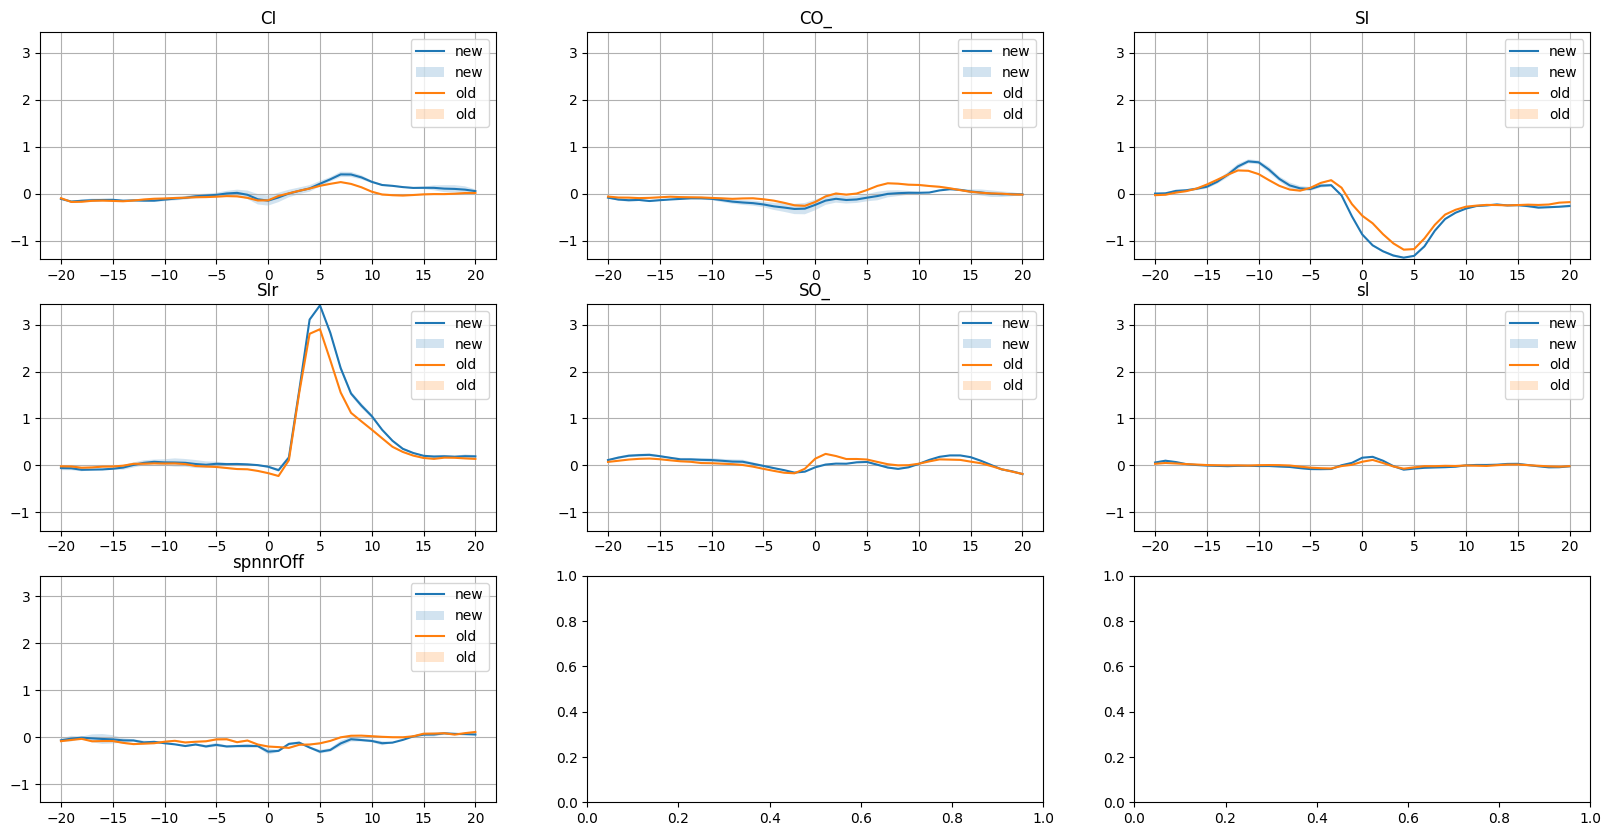

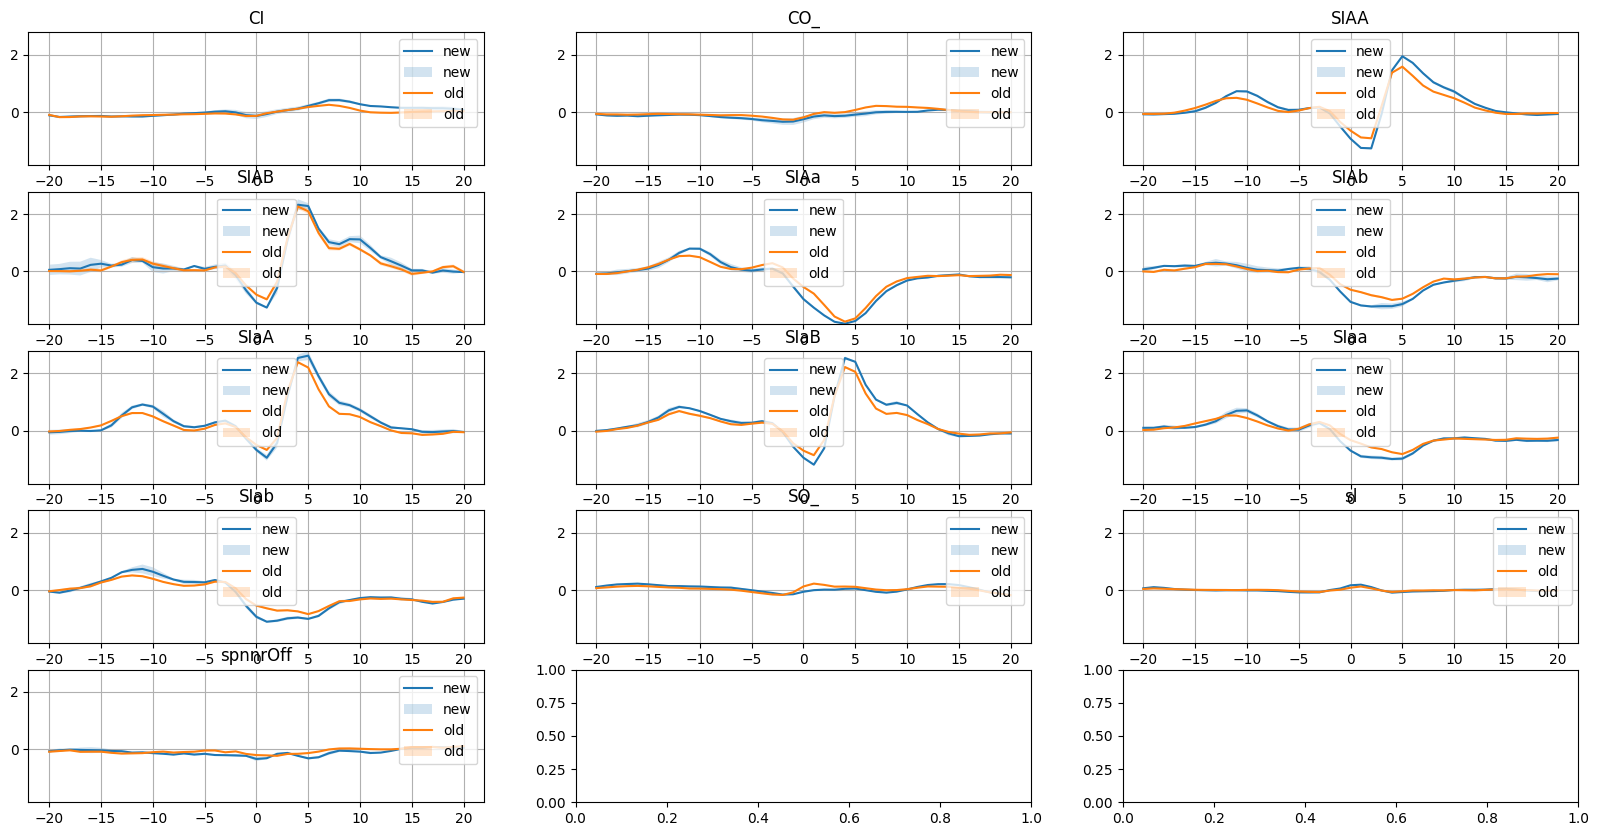

In [16]:
scores = defaultdict(list)

max_cols_len_lst = [max([len(_['X_cols']) for _ in inner_list]) for inner_list in X_y_pairings_lst]
for iXyp, X_y_pairings in enumerate(X_y_pairings_lst):
    for iXyd, X_y_dct in enumerate(X_y_pairings):
        if iXyd == 0:
            gb_coefs_b = pd.read_csv('/Users/josh/Documents/github_repos/sabatinilab-glm/sglm/outputs_lynne-sanity-comp/Figure_1_2-kernels_raw-gDA=0_base_simple.csv').iloc[:, 4:]
        else:
            gb_coefs_b = pd.read_csv('/Users/josh/Documents/github_repos/sabatinilab-glm/sglm/outputs_lynne-sanity-comp/Figure_1_2-kernels_raw-gDA=8_base_words.csv').iloc[:, 4:]
            
        for igkwargs, glm_kwargs in enumerate(glm_kwarg_lst):
            agg_coefs_lst = []
            for irun in range(num_runs):
                run_start = time.time()
                
                Xyp_path = param_set_output_path / Path(f'iXyp_{iXyp}')
                run_path = Xyp_path / Path(f'iXyd_{iXyd}-ikwargs_{igkwargs}') / Path(f'irun_{irun}')
                fitted_glm = read_json(run_path / 'fitted_glm.json')
                
                scores[f'{iXyp}_{iXyd}'].append(fitted_glm)
                
                coefs = pd.DataFrame(list(zip(fitted_glm['model']['X_names_'], fitted_glm['model']['coef_'])), columns=['name', 'coef'])
                coefs['name_lst'] = coefs['name'].str.split('_sft_')
                coefs['col'] = coefs['name_lst'].apply(lambda x: x[0])
                coefs['sft'] = coefs['name_lst'].apply(lambda x: x[1]).astype('int')
                
                agg_coefs_lst.append(coefs)
            
            agg_coefs = pd.concat(agg_coefs_lst)

            gb_coefs = agg_coefs.groupby(['col', 'sft'])['coef'].agg([np.mean, np.std, np.size])
            
            
            gb_coefs['lb_x'] = gb_coefs['mean'] - gb_coefs['std']/np.sqrt(gb_coefs['size'])*1.96
            gb_coefs['ub_x'] = gb_coefs['mean'] + gb_coefs['std']/np.sqrt(gb_coefs['size'])*1.96
            
            npr = 3
            
            gb_coefs = gb_coefs.reset_index()
            
            
            
            
            gb_coefs['match'] = gb_coefs['col'].astype(str) + '_' + gb_coefs['sft'].astype(str)
            gb_coefs_b['1'] = 1
            gb_coefs_b = gb_coefs_b.groupby('1').agg(['mean', 'std', 'size']).stack(0).droplevel(0).reset_index().rename({'index': 'match'}, axis=1)
            gb_combo = gb_coefs.merge(gb_coefs_b, on='match', how='outer')

            with pd.option_context('display.max_rows', 1000):
                display(gb_combo)
            
            
            
            gb_combo['lb_y'] = gb_combo['mean_y'] - gb_combo['std_y']/np.sqrt(gb_combo['size_y'])*1.96
            gb_combo['ub_y'] = gb_combo['mean_y'] + gb_combo['std_y']/np.sqrt(gb_combo['size_y'])*1.96
            
            
            fig,axes = plt.subplots(gb_coefs['col'].nunique()//npr+(gb_coefs['col'].nunique()%npr > 0)*1,npr,figsize=(20,10))

            min_y = min(gb_combo['lb_x'].min(), gb_combo['lb_y'].min())-0.01
            max_y = max(gb_combo['ub_x'].max(), gb_combo['ub_y'].max())+0.01
            i = 0
            for gc, gc_df in gb_combo.groupby('col'):
                axes[i//(npr),i%(npr)].set_title(gc.replace('Index','').replace('photometry','').replace('enter','').replace('ut','_').replace('ide','').replace('In','I'))
                axes[i//(npr),i%(npr)].plot(gc_df['sft'], gc_df['mean_x'], label='new')
                axes[i//(npr),i%(npr)].fill_between(gc_df['sft'], gc_df['lb_x'], gc_df['ub_x'], alpha=0.2, label='new')
                
                axes[i//(npr),i%(npr)].plot(gc_df['sft'], gc_df['mean_y'], label='old')
                axes[i//(npr),i%(npr)].fill_between(gc_df['sft'], gc_df['lb_y'], gc_df['ub_y'], alpha=0.2, label='old')
                
                axes[i//(npr),i%(npr)].grid(True)
                axes[i//(npr),i%(npr)].legend()
                i += 1

            i = 0
            for gc, gc_df in gb_coefs.groupby('col'):
                axes[i//(npr),i%(npr)].set_ylim((min_y, max_y))
                i += 1

In [17]:
gb_coefs['match'] = gb_coefs['col'].astype(str) + '_' + gb_coefs['sft'].astype(str)

In [18]:
gb_coefs

,col,sft,mean,std,size,lb_x,ub_x,match
0,photometryCenterInIndex,-20,-0.112206,0.011260,3,-0.124947,-0.099464,photometryCenterInIndex_-20
1,photometryCenterInIndex,-19,-0.169568,0.014559,3,-0.186043,-0.153093,photometryCenterInIndex_-19
2,photometryCenterInIndex,-18,-0.155355,0.026257,3,-0.185068,-0.125642,photometryCenterInIndex_-18
3,photometryCenterInIndex,-17,-0.144088,0.032478,3,-0.180840,-0.107335,photometryCenterInIndex_-17
4,photometryCenterInIndex,-16,-0.137878,0.027208,3,-0.168667,-0.107089,photometryCenterInIndex_-16
...,...,...,...,...,...,...,...,...
528,spnnrOff,16,0.058289,0.035092,3,0.018578,0.098000,spnnrOff_16
529,spnnrOff,17,0.083516,0.018347,3,0.062754,0.104278,spnnrOff_17
530,spnnrOff,18,0.070065,0.026344,3,0.040254,0.099876,spnnrOff_18
531,spnnrOff,19,0.066340,0.010146,3,0.054859,0.077822,spnnrOff_19


<AxesSubplot: >

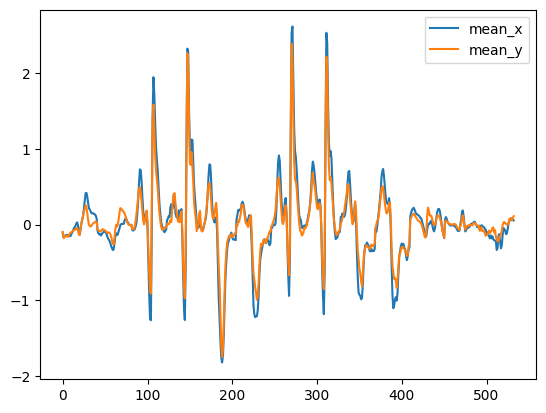

In [19]:
gb_coefs_b = pd.read_csv('/Users/josh/Documents/github_repos/sabatinilab-glm/sglm/outputs_lynne-sanity-comp/Figure_1_2-kernels_raw-gDA=8_base_words.csv').iloc[:, 4:]
gb_coefs_b['1'] = 1
gb_coefs_b = gb_coefs_b.groupby('1').agg(['mean', 'std', 'size']).stack(0).droplevel(0).reset_index().rename({'index': 'match'}, axis=1)
# gb_coefs_b

gb_combo = gb_coefs.merge(gb_coefs_b, on='match', how='outer')

# with pd.option_context('display.max_rows', 1000):
#     display(gb_combo)

gb_combo[['mean_x', 'mean_y']].plot()

<AxesSubplot: >

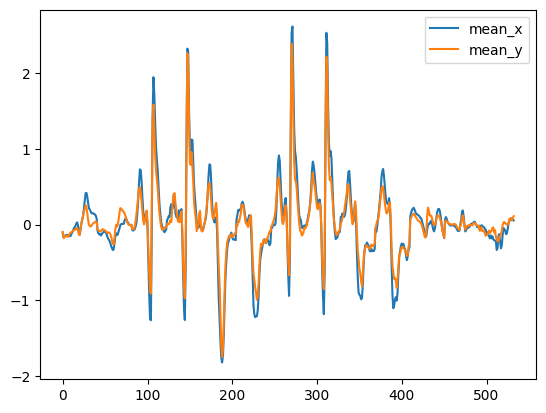

In [20]:
# gb_coefs_b = pd.read_csv('/Users/josh/Documents/github_repos/sabatinilab-glm/sglm/outputs_lynne-sanity-comp/Figure_1_2-kernels_raw-gDA=0_base_simple.csv').iloc[:, 4:]
gb_coefs_b = pd.read_csv('/Users/josh/Documents/github_repos/sabatinilab-glm/sglm/outputs_lynne-sanity-comp/Figure_1_2-kernels_raw-gDA=8_base_words.csv').iloc[:, 4:]
gb_coefs_b['1'] = 1
gb_coefs_b = gb_coefs_b.groupby('1').agg(['mean', 'std', 'size']).stack(0).droplevel(0).reset_index().rename({'index': 'match'}, axis=1)
# gb_coefs_b

gb_combo = gb_coefs.merge(gb_coefs_b, on='match', how='outer')

# with pd.option_context('display.max_rows', 1000):
#     display(gb_combo)

gb_combo[['mean_x', 'mean_y']].plot()

7.052448034286499
7.133435964584351


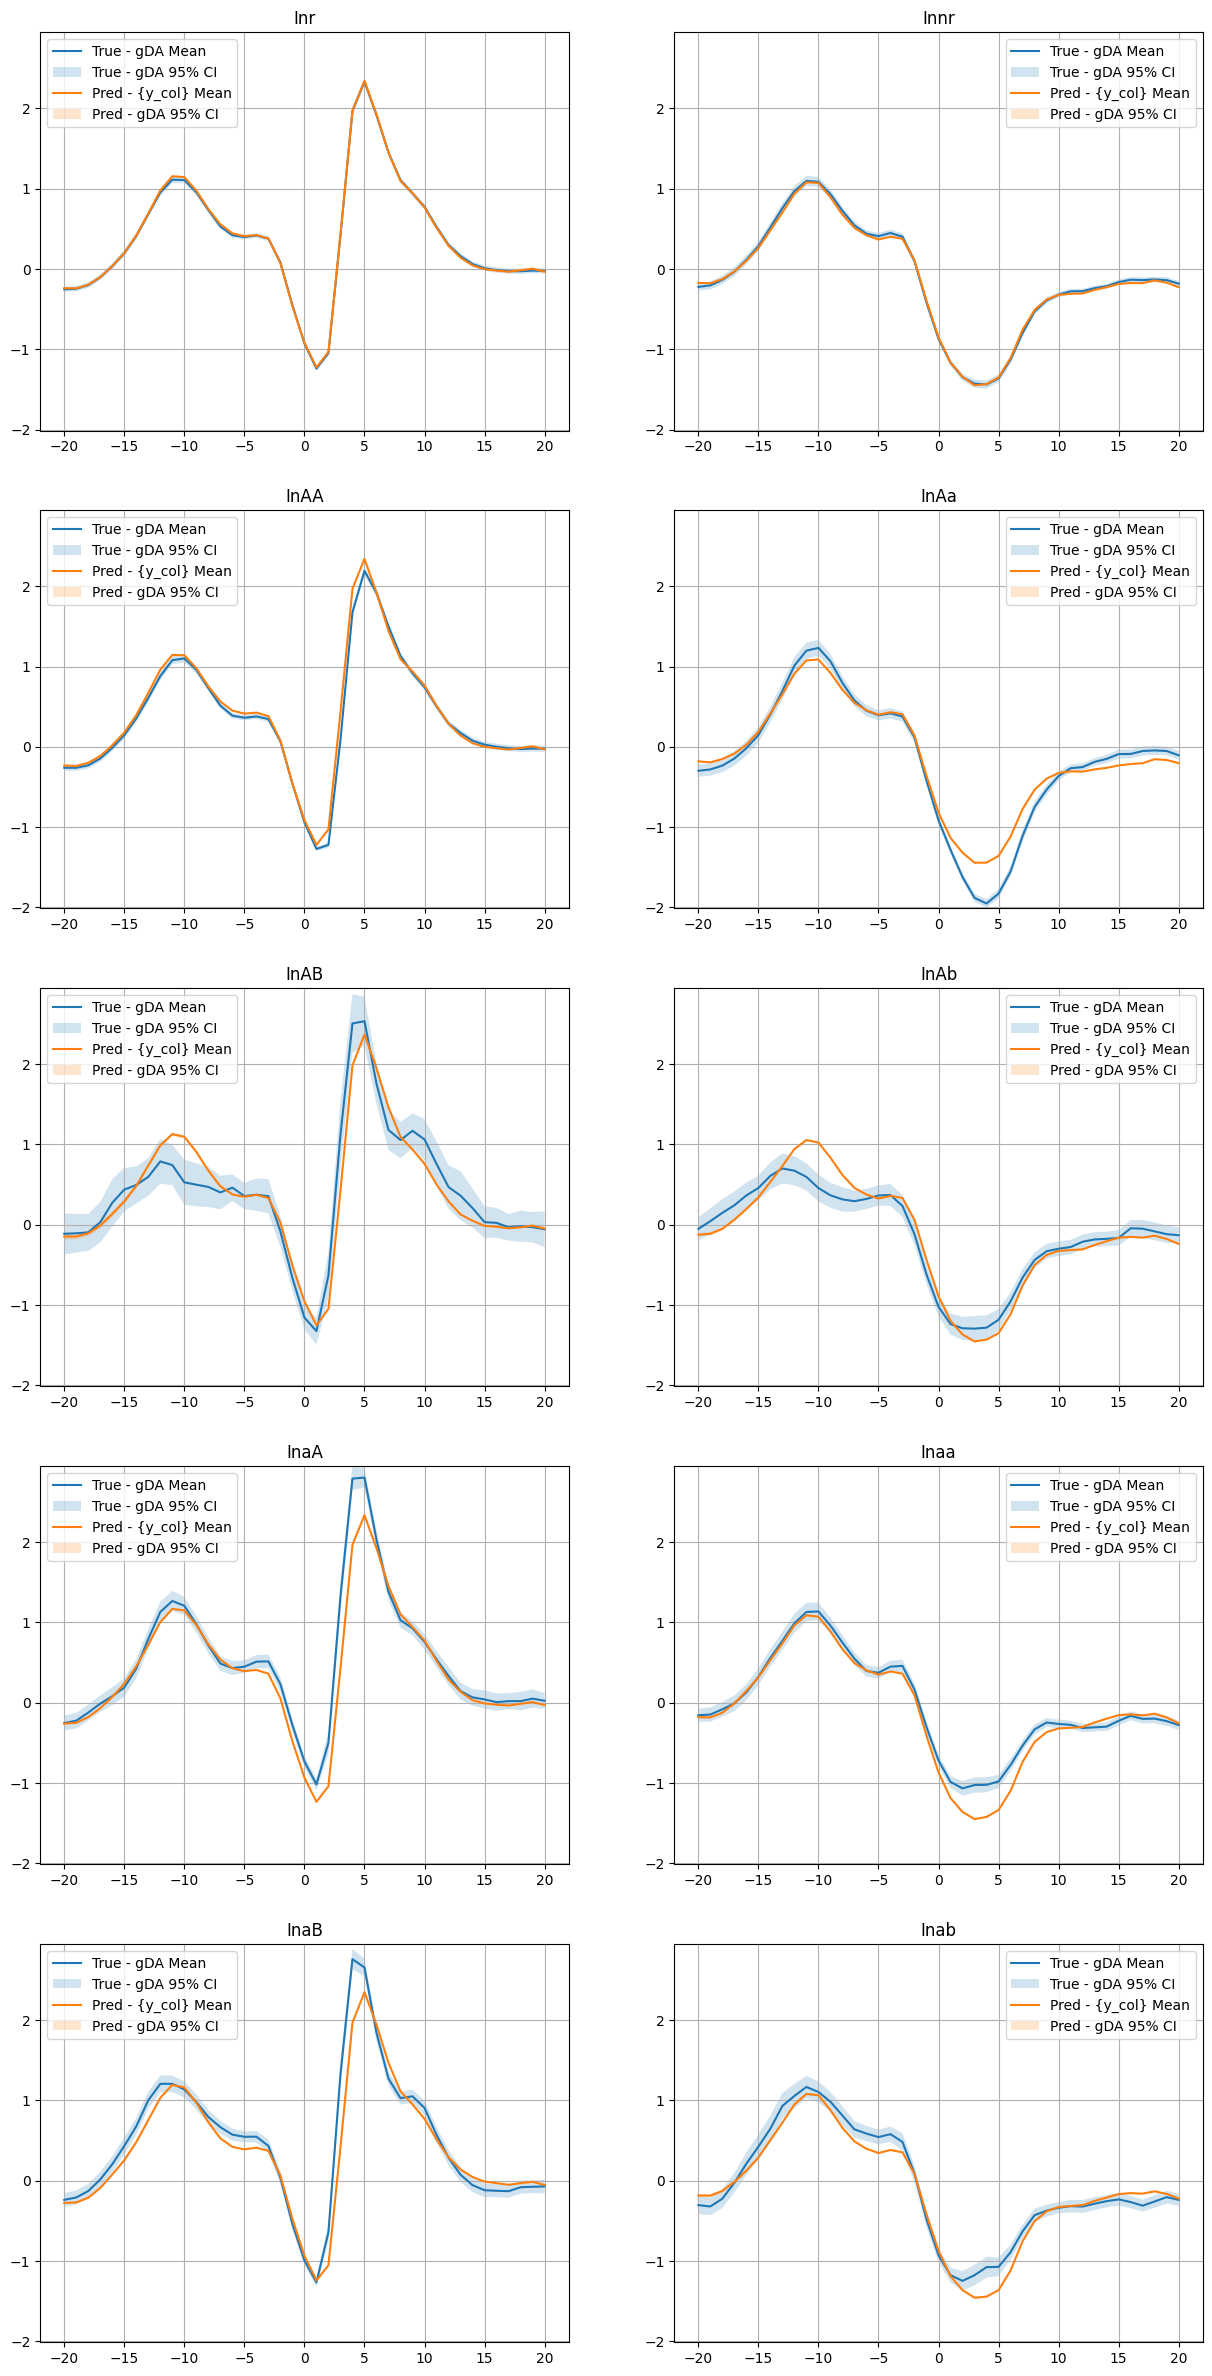

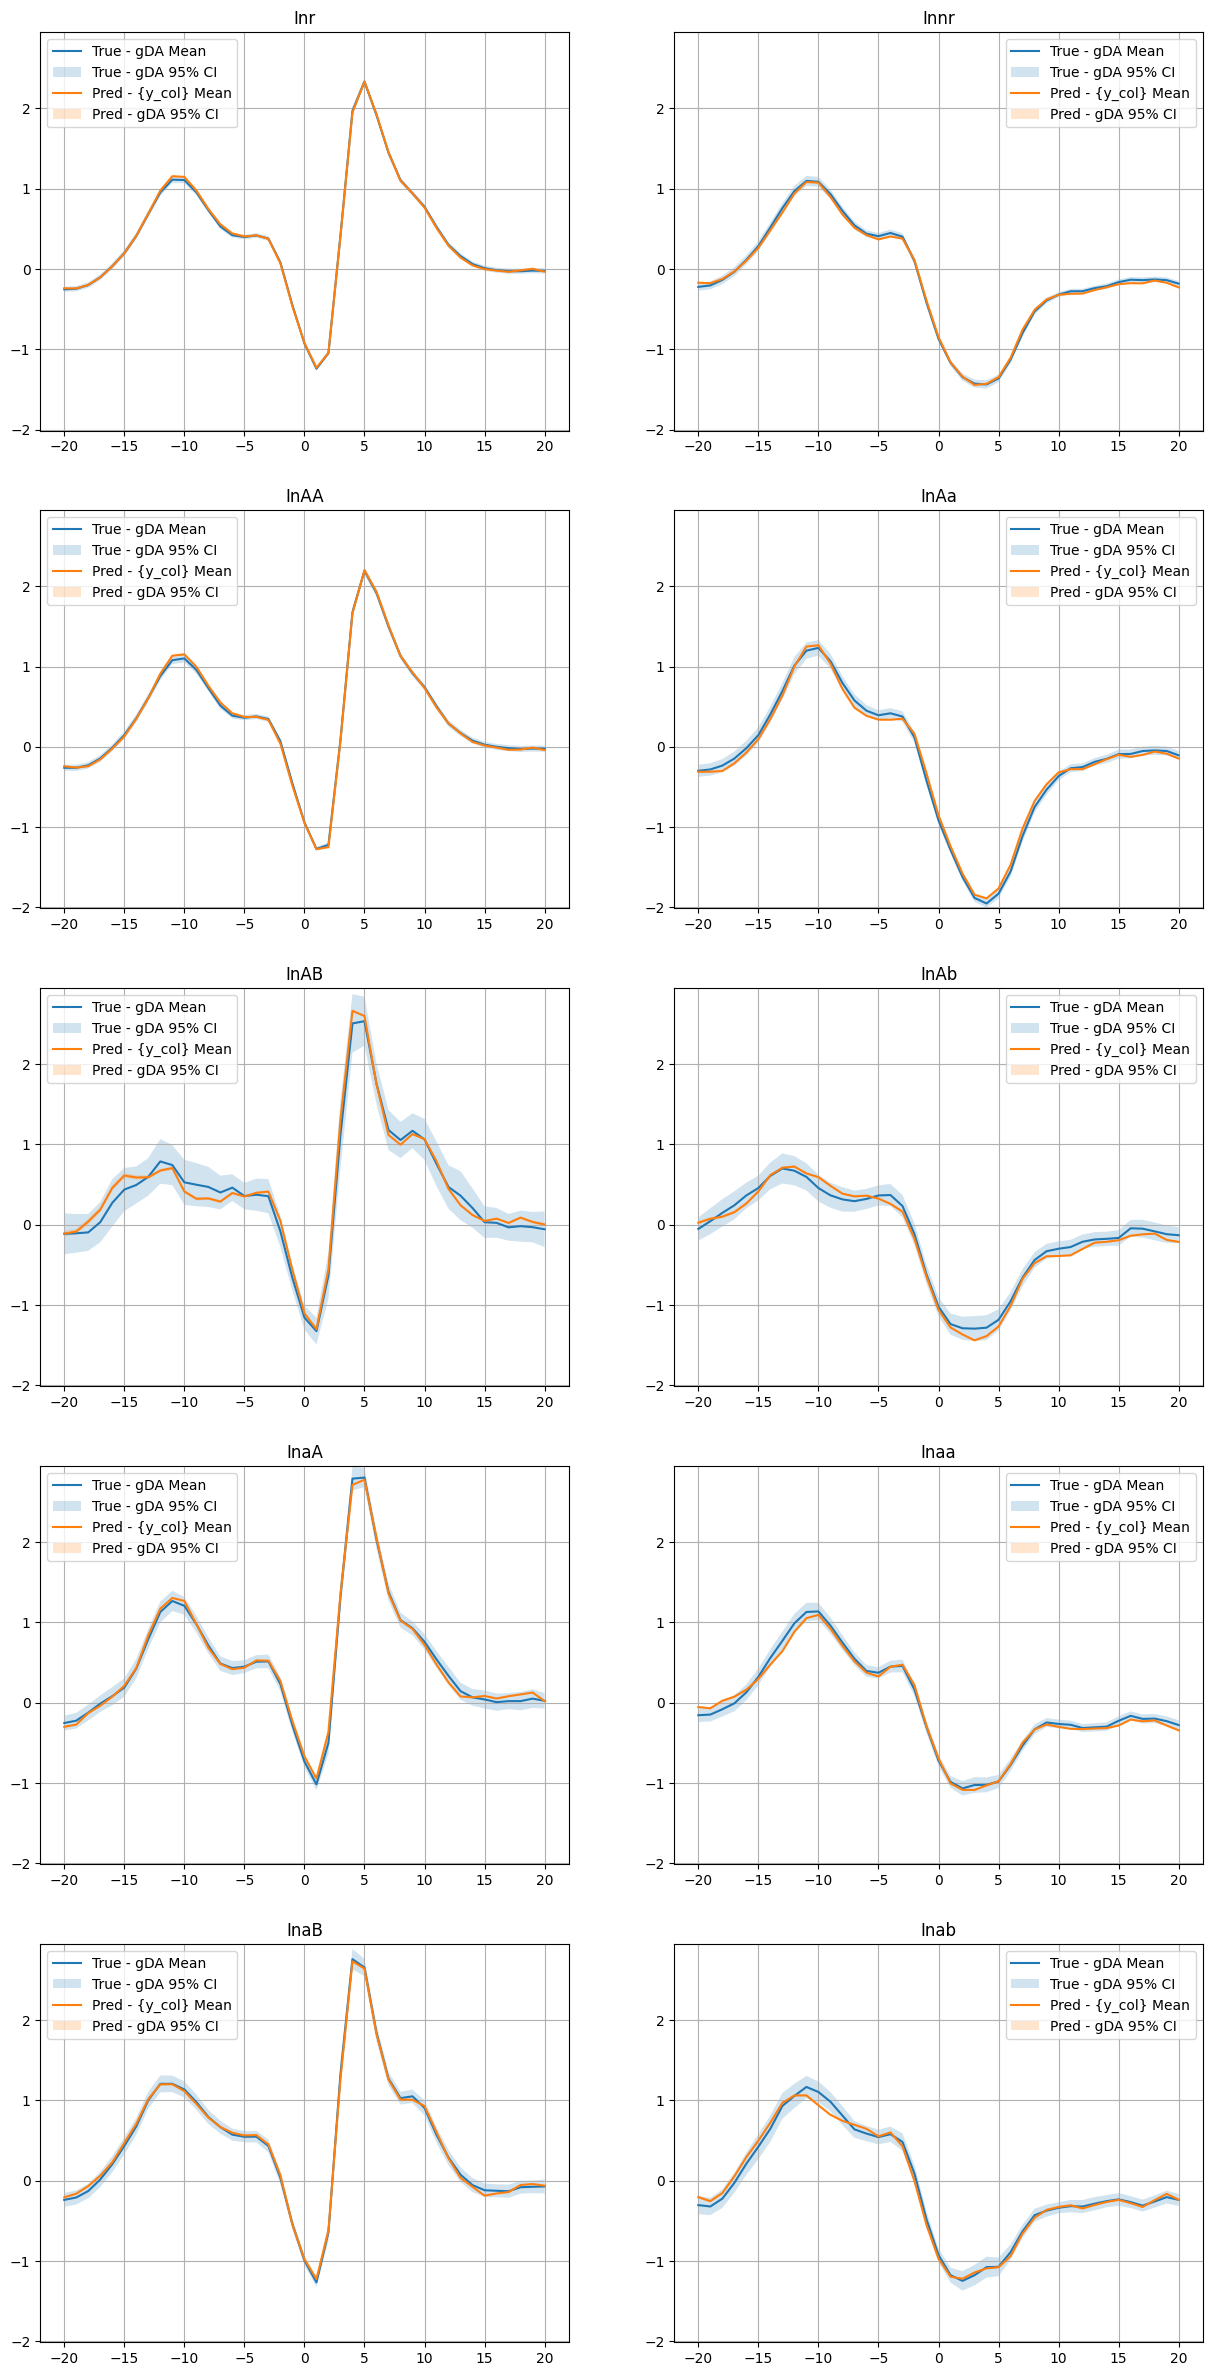

In [21]:
# break

max_cols_len_lst = [max([len(_['X_cols']) for _ in inner_list]) for inner_list in X_y_pairings_lst]
for iXyp, _ in enumerate(X_y_pairings_lst):
    for iXyd, X_y_dct in enumerate(X_y_pairings):
        for igkwargs, glm_kwargs in enumerate(glm_kwarg_lst):
            irun = 0
            
            run_start = time.time()
            Xyp_path = param_set_output_path / Path(f'iXyp_{iXyp}')
            run_path = Xyp_path / Path(f'iXyd_{iXyd}-ikwargs_{igkwargs}') / Path(f'irun_{irun}')
            preds_df = pd.read_csv(run_path / 'preds.csv', low_memory=False, index_col=0)
            preds_df = preds_df[preds_df['has_all_cols']].copy()
            
            preds_df['photometrySideInIndex'] = preds_df['photometrySideInIndexr'] + preds_df['photometrySideInIndexnr']
            
            alignment_cols = [#'photometrySideOutIndexLt', 'photometrySideOutIndexRt',
                              
                              'photometrySideInIndexr', 'photometrySideInIndexnr',
                              'photometrySideInIndexAA', 'photometrySideInIndexAa',
                              'photometrySideInIndexAB', 'photometrySideInIndexAb',
                              'photometrySideInIndexaA', 'photometrySideInIndexaa',
                              'photometrySideInIndexaB', 'photometrySideInIndexab',
                             ]
            for alignment_col in alignment_cols:
                
                preds_df['ac_tmp'] = ((~preds_df['dupe'])*1.0)*((preds_df['diffTrialNums']==1.0)*1.0)*preds_df[alignment_col]
                preds_df['entryTime'] = preds_df.groupby(['nTrial_filenum'])['ac_tmp'].transform(np.argmax)

                preds_df['timestep'] = 1
                preds_df['timestep'] = preds_df.groupby(['nTrial_filenum'])['timestep'].cumsum() - 1
                preds_df['timestep'] = preds_df['timestep'] - preds_df['entryTime']
                
                preds_df[f'has_{alignment_col}'] = preds_df.groupby(['nTrial_filenum'])['ac_tmp'].transform(np.sum)
                preds_df[f'ts_{alignment_col}'] = preds_df['timestep']
            
            assert preds_df['holdout'].isna().sum() == 0
            preds_df['holdout'] = preds_df['holdout'].astype(bool)
            
            y_col = X_y_dct['y_col']
            preds_df['resids'] = preds_df[y_col] - preds_df['pred_'+y_col]
            preds_df['residsALL'] = preds_df[y_col] - preds_df['predALL_'+y_col]
            
            filt = (~preds_df['holdout'])&preds_df['wi_trial_keep']
            preds_df_train = preds_df[(~preds_df['holdout'])&preds_df['wi_trial_keep']]
            preds_df_holdout = preds_df[(preds_df['holdout'])&preds_df['wi_trial_keep']]
            
            print(time.time() - run_start)
            
            min_y = +np.inf
            max_y = -np.inf

            fig, axes = plt.subplots(len(alignment_cols)//2,2,figsize=(15,30))
            for iac, alignment_col in enumerate(alignment_cols):
                holdout_agg = preds_df[preds_df[f'has_{alignment_col}'] == 1.0]
                holdout_agg = holdout_agg.groupby([f'ts_{alignment_col}'])[[f'{y_col}', f'pred_{y_col}']].agg([np.mean, np.std, np.size]).dropna()                
                holdout_agg.columns = ['-'.join(_) for _ in holdout_agg.columns]

                holdout_agg = holdout_agg[holdout_agg.assign(timestep=holdout_agg.index)['timestep'].between(-20,20)]                

                holdout_agg[f'{y_col}-lb'] = holdout_agg[f'{y_col}-mean'] - 1.96* holdout_agg[f'{y_col}-std']/np.sqrt(holdout_agg[f'{y_col}-size'])
                holdout_agg[f'{y_col}-ub'] = holdout_agg[f'{y_col}-mean'] + 1.96* holdout_agg[f'{y_col}-std']/np.sqrt(holdout_agg[f'{y_col}-size'])

                holdout_agg[f'pred_{y_col}-lb'] = holdout_agg[f'pred_{y_col}-mean'] - holdout_agg[f'pred_{y_col}-std']/np.sqrt(holdout_agg[f'pred_{y_col}-size'])
                holdout_agg[f'pred_{y_col}-ub'] = holdout_agg[f'pred_{y_col}-mean'] + holdout_agg[f'pred_{y_col}-std']/np.sqrt(holdout_agg[f'pred_{y_col}-size'])

                min_y = min(min_y, min(holdout_agg[f'{y_col}-lb'].min()-0.01, holdout_agg[f'pred_{y_col}-lb'].min()-0.01))
                max_y = max(max_y, max(holdout_agg[f'{y_col}-ub'].max()+0.01, holdout_agg[f'pred_{y_col}-ub'].max()+0.01))

                axes[iac//2,iac%2].set_title(alignment_col.replace('photometrySide','').replace('Index',''))
                axes[iac//2,iac%2].plot(holdout_agg[f'{y_col}-mean'], label=f'True - {y_col} Mean')
                axes[iac//2,iac%2].fill_between(holdout_agg.index, holdout_agg[f'{y_col}-lb'], holdout_agg[f'{y_col}-ub'], alpha=0.2, label=f'True - {y_col} 95% CI')
                axes[iac//2,iac%2].plot(holdout_agg[f'pred_{y_col}-mean'], label='Pred - {y_col} Mean')
                axes[iac//2,iac%2].fill_between(holdout_agg.index, holdout_agg[f'pred_{y_col}-lb'], holdout_agg[f'pred_{y_col}-ub'], alpha=0.2, label=f'Pred - {y_col} 95% CI')
                axes[iac//2,iac%2].grid(True)
                axes[iac//2,iac%2].legend()


            i = 0
            for iac in enumerate(alignment_cols):
                axes[i//2,i%2].set_ylim((min_y, max_y))
                i += 1



In [22]:
# tmp = (preds_df.groupby(['nTrial_filenum'])['ac_tmp'].sum())
# tmp[tmp > 1]


# with pd.option_context('display.max_rows',10000,'display.max_columns',10000):
#     display(preds_df[preds_df['nTrial_filenum'] == 1095].iloc[:, list(range(30))].replace(0,np.nan))#+list(range(-20,0))])

In [23]:
def bootstrap_to_lower_upper_bounds(x, func, **kwargs):
    bs = scipy.stats.bootstrap((x,), func, **kwargs)
    return [bs.confidence_interval.low, bs.confidence_interval.high]

  0%|          | 0/10 [00:00<?, ?it/s]

,true_lb,true_mean,true_ub,pred_lb,pred_mean,pred_ub
ts_photometrySideInIndexab,,,,,,
-20,-0.378542,-0.304374,-0.182596,-0.240294,-0.204531,-0.183193
-19,-0.395613,-0.321455,-0.265023,-0.284714,-0.255062,-0.237787
-18,-0.286553,-0.223996,-0.132311,-0.191126,-0.154309,-0.136819
-17,-0.101287,-0.027095,0.068797,0.025947,0.054661,0.072378
-16,0.143502,0.211479,0.333670,0.268425,0.293507,0.308212
-15,0.385499,0.423156,0.548329,0.489973,0.497918,0.520634
-14,0.579333,0.647633,0.721465,0.681460,0.722846,0.742751
-13,0.879662,0.930601,1.007592,0.937824,0.968514,0.987553
-12,0.974094,1.055130,1.109178,1.038837,1.060867,1.076107


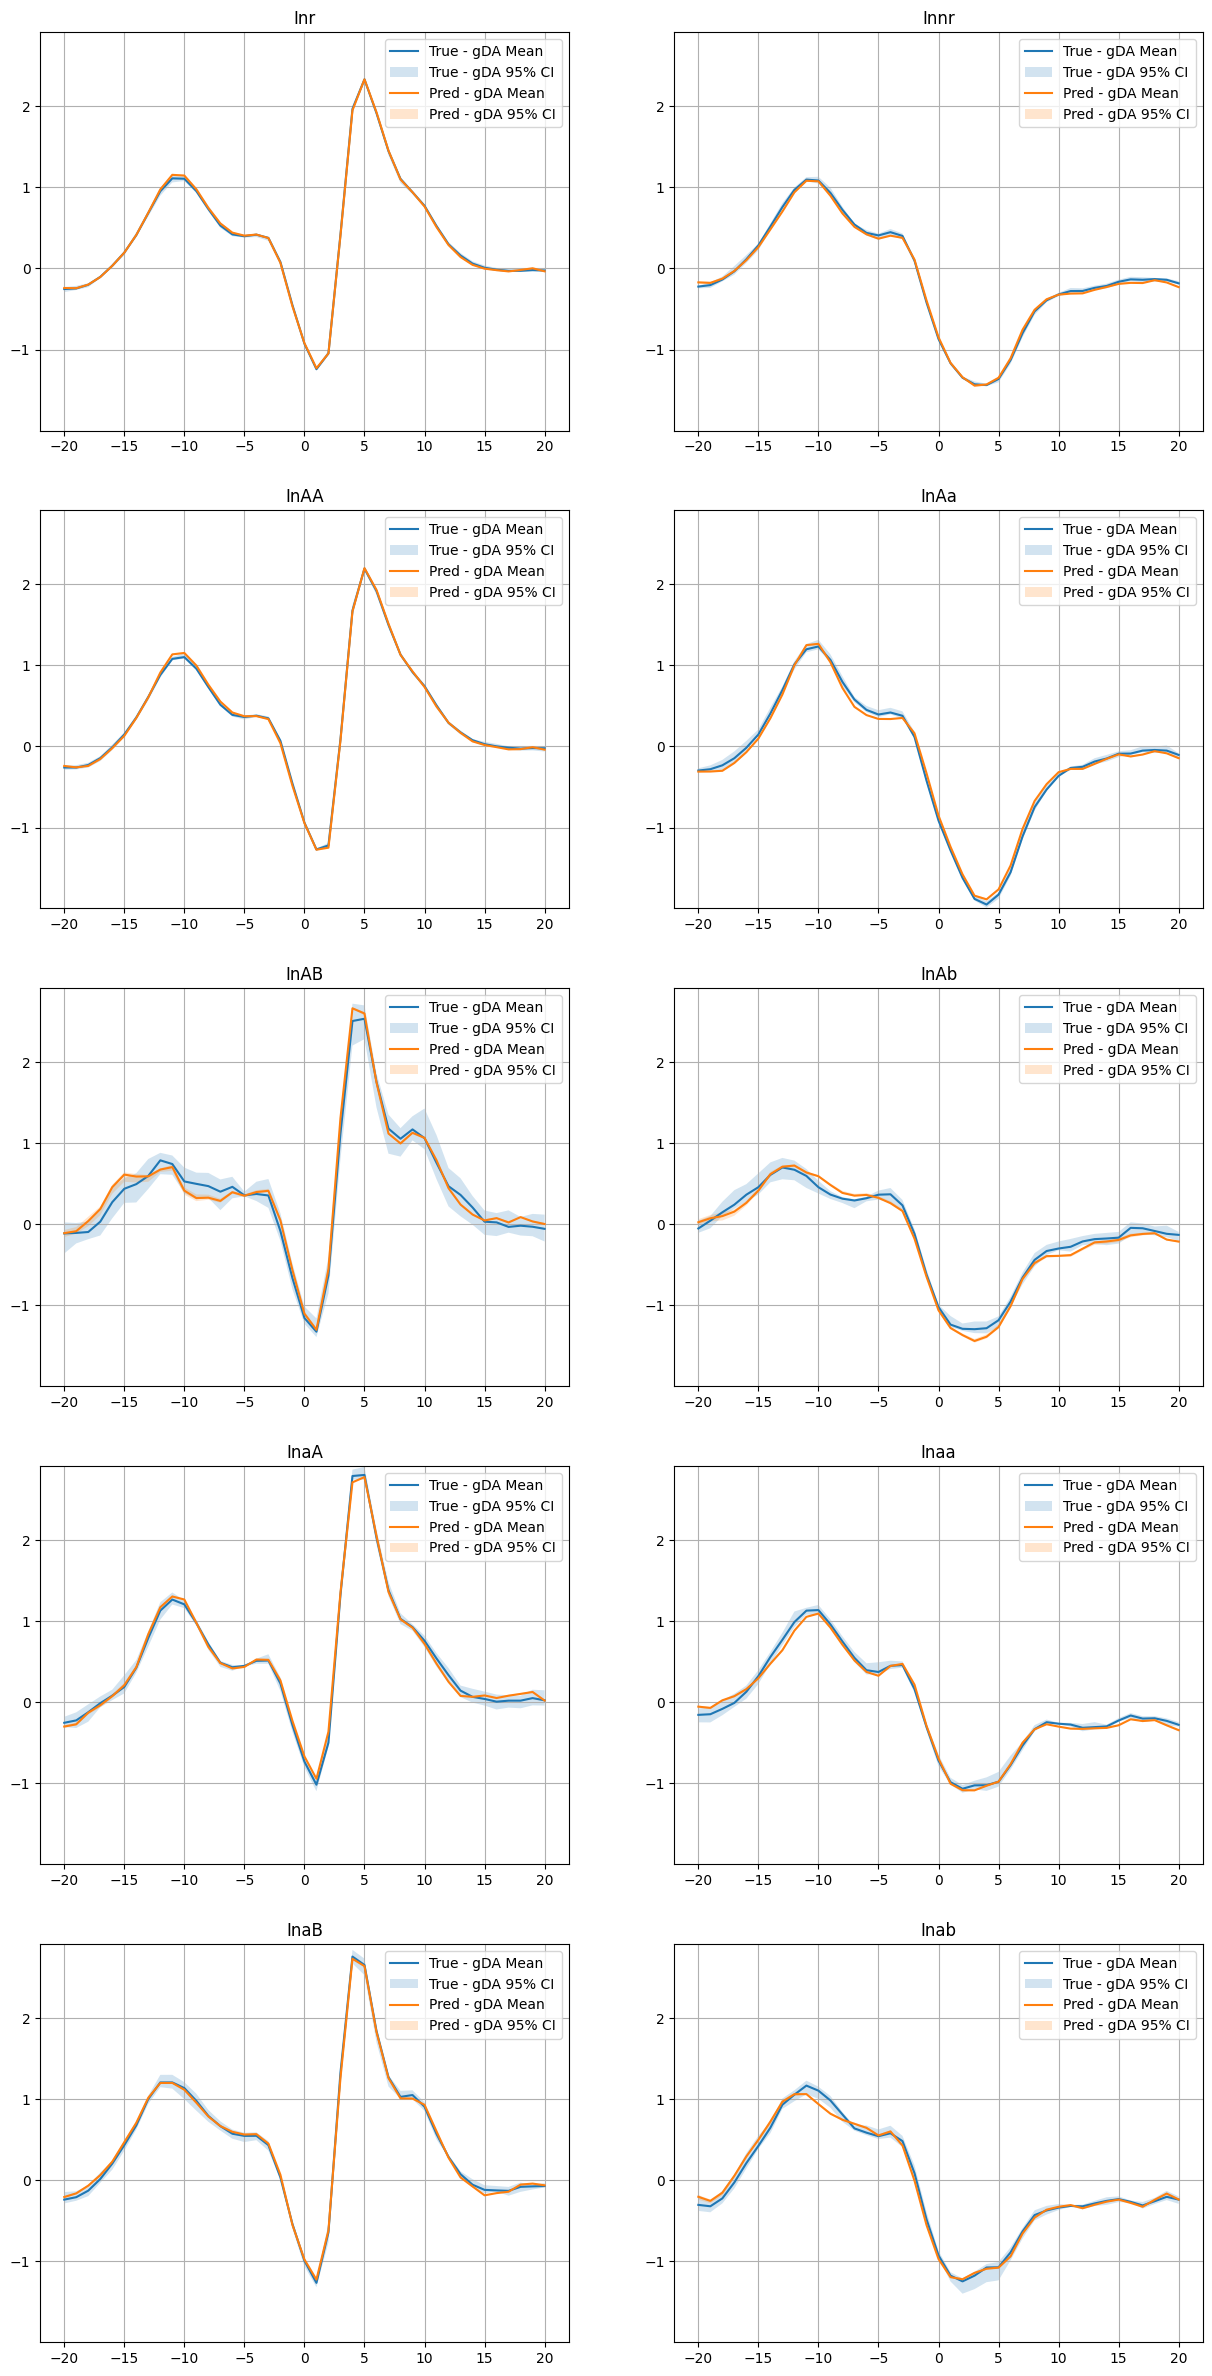

In [24]:
import scipy
from tqdm.notebook import tqdm

seed = np.random.randint(1000000000)
boot_kwargs = dict(n_resamples=10,
               batch=None, vectorized=True, paired=False,
               axis=0, confidence_level=0.95, method='BCa',
               random_state=seed)

min_y = +np.inf
max_y = -np.inf

fig, axes = plt.subplots(len(alignment_cols)//2,2,figsize=(15,30))
for iac, alignment_col in tqdm(enumerate(alignment_cols), total=len(alignment_cols)):
    
    holdout_agg = preds_df[preds_df[f'has_{alignment_col}'] == 1.0]
    holdout_agg = holdout_agg.dropna()
    holdout_agg = holdout_agg[holdout_agg.assign(timestep=holdout_agg[f'ts_{alignment_col}'])['timestep'].between(-20,20)]
#     display(holdout_agg)
    
    true_srs = holdout_agg.groupby(f'ts_{alignment_col}')[f'{y_col}'].apply(lambda x: np.array(x))
    pred_srs = holdout_agg.groupby(f'ts_{alignment_col}')[f'pred_{y_col}'].apply(lambda x: np.array(x))
    
    boot_df_setup = pd.DataFrame({
                            'true_mean':true_srs.apply(np.mean),
                            'pred_mean':pred_srs.apply(np.mean),

                            'true_lb_ub':true_srs.apply(lambda x: bootstrap_to_lower_upper_bounds(x, np.mean, **boot_kwargs)),
                            'pred_lb_ub':pred_srs.apply(lambda x: bootstrap_to_lower_upper_bounds(x, np.mean, **boot_kwargs)),
                           })
    
    
    boot_df_setup['true_lb'] = boot_df_setup['true_lb_ub'].apply(lambda x: x[0])
    boot_df_setup['true_ub'] = boot_df_setup['true_lb_ub'].apply(lambda x: x[1])
    boot_df_setup['pred_lb'] = boot_df_setup['pred_lb_ub'].apply(lambda x: x[0])
    boot_df_setup['pred_ub'] = boot_df_setup['pred_lb_ub'].apply(lambda x: x[1])

    boot_df = boot_df_setup[['true_lb', 'true_mean', 'true_ub',
             'pred_lb', 'pred_mean', 'pred_ub',]]
    
    
#     for sft in true_srs.index:
#         sft_data = true_srs.loc[sft]
#         bs = scipy.stats.bootstrap((row,), np.mean, n_resamples=9999,
#                                batch=None, vectorized=True, paired=False,
#                                axis=0, confidence_level=0.95, method='BCa',
#                                random_state=seed)
    

#         rtup = (bootstrap_col, delta, bs.confidence_interval.low, mn_val, bs.confidence_interval.high)

#         reconstruction_data_list.append(rtup)

#         tmp_combo_rdc = pd.DataFrame(reconstruction_data_list, columns=['basis_column', 'delta', 'lb', 'mn', 'ub']).set_index('delta')
    
    
    min_y = min(min_y, min(boot_df['true_lb'].min()-0.01, boot_df['true_lb'].min()-0.01))
    max_y = max(max_y, max(boot_df['true_ub'].max()+0.01, boot_df['true_ub'].max()+0.01))

    axes[iac//2,iac%2].set_title(alignment_col.replace('photometrySide','').replace('Index',''))
    axes[iac//2,iac%2].plot(boot_df['true_mean'], label=f'True - {y_col} Mean')
    axes[iac//2,iac%2].fill_between(boot_df.index, boot_df['true_lb'], boot_df['true_ub'], alpha=0.2, label=f'True - {y_col} 95% CI')
    axes[iac//2,iac%2].plot(boot_df['pred_mean'], label=f'Pred - {y_col} Mean')
    axes[iac//2,iac%2].fill_between(boot_df.index, boot_df['pred_lb'], boot_df['pred_ub'], alpha=0.2, label=f'Pred - {y_col} 95% CI')
    axes[iac//2,iac%2].grid(True)
    axes[iac//2,iac%2].legend()

i = 0
for iac in enumerate(alignment_cols):
    axes[i//2,i%2].set_ylim((min_y, max_y))
    i += 1

boot_df
    

In [25]:
for k in scores:
    df = pd.DataFrame([_['score'] for _ in scores[k]])
    display(df[[_ for _ in df.columns if 'mse' in _]])

,mse_tr,mse_cv,mse_te
0,0.657511,0.663419,0.653020
1,0.646136,0.648445,0.664749
2,0.654773,0.658457,0.656109


,mse_tr,mse_cv,mse_te
0,0.646026,0.655265,0.644154
1,0.635669,0.640164,0.654797
2,0.642139,0.649392,0.648552


In [26]:
# vs. MSEs around .78 / .8 something for Lynne's original fit
# Suspiction: Not exactly the same set of files being examined
# Not exactly the same set of timepoints being compared
# Not exctly the same set of predictors used
# Not exactly the same preprocessing stepsb

In [27]:
df.shape

(3, 6)

In [28]:
boot_df

,true_lb,true_mean,true_ub,pred_lb,pred_mean,pred_ub
ts_photometrySideInIndexab,,,,,,
-20,-0.378542,-0.304374,-0.182596,-0.240294,-0.204531,-0.183193
-19,-0.395613,-0.321455,-0.265023,-0.284714,-0.255062,-0.237787
-18,-0.286553,-0.223996,-0.132311,-0.191126,-0.154309,-0.136819
-17,-0.101287,-0.027095,0.068797,0.025947,0.054661,0.072378
-16,0.143502,0.211479,0.333670,0.268425,0.293507,0.308212
-15,0.385499,0.423156,0.548329,0.489973,0.497918,0.520634
-14,0.579333,0.647633,0.721465,0.681460,0.722846,0.742751
-13,0.879662,0.930601,1.007592,0.937824,0.968514,0.987553
-12,0.974094,1.055130,1.109178,1.038837,1.060867,1.076107


In [29]:


# min_y = +np.inf
# max_y = -np.inf

# fig, axes = plt.subplots(len(alignment_cols)//2,2,figsize=(15,30))
# for iac, alignment_col in enumerate(alignment_cols):
#     holdout_agg = preds_df[preds_df[f'has_{alignment_col}'] == 1.0]
#     holdout_agg = holdout_agg.groupby([f'ts_{alignment_col}'])[['true', 'pred']].agg([np.mean, np.std, np.size]).dropna()
#     holdout_agg.columns = ['-'.join(_) for _ in holdout_agg.columns]

#     holdout_agg = holdout_agg[holdout_agg.assign(timestep=holdout_agg.index)['timestep'].between(-20,20)]                

#     min_y = min(min_y, min(holdout_agg['true_lb'].min()-0.01, holdout_agg['true_lb'].min()-0.01))
#     max_y = max(max_y, max(holdout_agg['true_ub'].max()+0.01, holdout_agg['true_ub'].max()+0.01))

#     axes[iac//2,iac%2].set_title(alignment_col.replace('photometrySide','').replace('Index',''))
#     axes[iac//2,iac%2].plot(holdout_agg['true_mean'], label='True - GCAMP Mean')
#     axes[iac//2,iac%2].fill_between(holdout_agg.index, holdout_agg['true_lb'], holdout_agg['true_ub'], alpha=0.2, label='True - GCAMP 95% CI')
#     axes[iac//2,iac%2].plot(holdout_agg['true_mean'], label='Pred - GCAMP Mean')
#     axes[iac//2,iac%2].fill_between(holdout_agg.index, holdout_agg['true_lb'], holdout_agg['true_ub'], alpha=0.2, label='Pred - GCAMP 95% CI')
#     axes[iac//2,iac%2].grid(True)
#     axes[iac//2,iac%2].legend()




In [30]:
# # stack all true values together--(along delta)
# # for delta long the rows... drop any nan values
# # bootstrap along the row


# seed = np.random.randint(1000000000)
# row = tmp_rdc.loc[delta].dropna().values
# bs = scipy.stats.bootstrap((row,), np.mean, n_resamples=9999,
#                            batch=None, vectorized=True, paired=False,
#                            axis=0, confidence_level=0.95, method='BCa',
#                            random_state=seed)

# mn_val = row.mean()
# rtup = (bootstrap_col, delta, bs.confidence_interval.low, mn_val, bs.confidence_interval.high)

# reconstruction_data_list.append(rtup)

# tmp_combo_rdc = pd.DataFrame(reconstruction_data_list, columns=['basis_column', 'delta', 'lb', 'mn', 'ub']).set_index('delta')


# seed = np.random.randint(1000000000)
# row = tmp_rdc.loc[delta].dropna().values
# bs = scipy.stats.bootstrap((row,), np.mean, n_resamples=9999,
#                            batch=None, vectorized=True, paired=False,
#                            axis=0, confidence_level=0.95, method='BCa',
#                            random_state=seed)

# mn_val = row.mean()
# rtup = (bootstrap_col, delta, bs.confidence_interval.low, mn_val, bs.confidence_interval.high)

# reconstruction_data_list.append(rtup)

# tmp_combo_rdc = pd.DataFrame(reconstruction_data_list, columns=['basis_column', 'delta', 'lb', 'mn', 'ub']).set_index('delta')


In [31]:
# preds_df_holdout.groupby(['nTrial_filenum', 'timestep'])[['GCAMP', 'pred_GCAMP']].agg([np.mean, np.std])

In [32]:



# [['GCAMP', 'pred_GCAMP']]